In [1]:
import pandas as pd 
import numpy as np

import tensorflow as tf
import os

from tensorflow.keras.preprocessing.text import Tokenizer   
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

### Loading and Cleaning

In [2]:
la = pd.read_csv("https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_collection/Los%20Angeles_restaurant.csv")
sd = pd.read_csv("https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_collection/San%20Diego_restaurant.csv")
sf = pd.read_csv("https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_collection/San%20Francisco_restaurant.csv")
oc = pd.read_csv("https://raw.githubusercontent.com/jacobh310/food_nlp/master/data_collection/Orange%20County_restaurant.csv")

In [3]:
def clean_name(col):
    if 'http' in col:
        col = col.split('Reviews')[1]
        col = col.split('-')[-2]
        col = col.replace('_',' ')
        return col
    else:
        return col

### For visualizing trainning loss and validation loss
import matplotlib.pyplot as plt 
def plot_loss(history):
  hist = pd.DataFrame(history.history)
  plt.plot(hist['mae'], label='training_mae')
  plt.plot(hist['val_mae'], label = 'validation_mae')
  plt.legend()
  plt.ylabel("loss")
  plt.xlabel("epochs")
  plt.show()

In [4]:
df = pd.concat([la,sd,oc,sf])
df['rating'] = df['rating']/10 
df['restaurant'] = df['restaurant'].apply(lambda x: clean_name(x))
df['restaurant'] = df['restaurant'].apply(lambda x: 'In-N-Out Burger' if 'In N Out' in x else x)
df = df[pd.to_numeric(df['review'], errors='coerce').isnull()]
df = df.dropna(subset=['rating','review'])

## Splitting Train Test Dev

In [5]:
def train_dev_test_df(df, splits):
    """"
    Takes in a dataframe and splits into train dev and test
    """
    np.random.seed(42)
    shuffle_df = df.sample(frac=1)

    train, dev = splits

    X = shuffle_df['review'].to_numpy()
    y = shuffle_df['rating'].to_numpy()

    train_cutoff = int(X.shape[0]*train)
    dev_cutoff = int(X.shape[0]*(train+dev))

    X_train = X[:train_cutoff]
    y_train = y[:train_cutoff]

    X_dev = X[train_cutoff:dev_cutoff]
    y_dev = y[train_cutoff:dev_cutoff]

    X_test = X[dev_cutoff:]
    y_test = y[dev_cutoff:]

    y_train = tf.constant(y_train, dtype=tf.int16)
    y_dev = tf.constant(y_dev, dtype = tf.int16)
    y_test = tf.constant(y_test, dtype=tf.int16)

    return X_train, y_train, X_dev, y_dev, X_test, y_test

In [58]:
X_train, y_train, X_dev, y_dev, X_test, y_test = train_dev_test_df(df,(.7,.15))

### Training model with no pretrained Embeddings

In [59]:
vocab_size = 20000
embedding_dim = 100
max_length = 200
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [60]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index_token = tokenizer.word_index

X_train_token = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_token, maxlen=max_length, padding=padding_type, truncating=trunc_type)

X_dev_token = tokenizer.texts_to_sequences(X_dev)
X_dev_padded = pad_sequences(X_dev_token, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [61]:
X_train_padded = tf.cast(X_train_padded, dtype=tf.int16)
X_dev_padded = tf.cast(X_dev_padded, dtype=tf.int16)

In [62]:
callback = tf.keras.callbacks.TensorBoard(log_dir='callbacks', histogram_freq=1)

In [ ]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(10,activation='relu'),
    Dense(1,activation='relu')
])

model.compile(loss='MAE',optimizer=tf.keras.optimizers.Adam() ,metrics=['mae'])

model.fit(X_train_padded, y_train, batch_size=128, epochs=30, validation_data=(X_dev_padded, y_dev), callbacks=callback)

In [ ]:
model.evaluate(X_dev_padded, y_dev)

254/254 [==============================] - 4s 14ms/step - loss: 0.5397 - mae: 0.5397


[0.5397411584854126, 0.5397411584854126]

In [ ]:
model.summary()

### Model Using Pretrained Glove Embeddingings

In [63]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-06-26 18:52:39--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-06-26 18:52:39--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-06-26 18:52:39--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [64]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(X_train).batch(128)
vectorizer.adapt(text_ds)

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [66]:
## Vectorizing the training examples
## Chaning the dtype of the samples and labels for faster processing

X_train_vector = tf.cast(vectorizer(X_train), tf.int32)
X_dev_vector = tf.cast(vectorizer(X_dev), tf.int32)

#### Functions Importing embeddings and making embedding matrix

In [67]:
def import_embeddings(path):
    """
    Loads embeddings from a text file
    """
    import os 
    path_to_glove_file = os.path.join(
      os.path.expanduser("~"), path
    )

    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))

    return embeddings_index



def make_embedding_matrix(word_index, embedding_dim, embeddings_index):
    """
    Returns embedding matrix
    """
    num_tokens = len(word_index) + 2
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))
    return embedding_matrix
    


In [129]:
def make_model(embedding_matrix, lstm_layer_units, dropout_rate, dense_units, lr=0.001, l2=False):
  """ 
  Returns compiled model with spcified number of hyper paramters
  """

  tf.random.set_seed(42)

  num_tokens, embedding_dim = embedding_matrix.shape

  model = tf.keras.Sequential()
  embedding_layer = Embedding(
      num_tokens,
      embedding_dim,
      embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
      trainable=False)
  
  model.add(embedding_layer)

  for units in lstm_layer_units[:-1]:
    model.add(Bidirectional(LSTM(units, return_sequences=True)))
    model.add(Dropout(dropout_rate))
  

  model.add(Bidirectional(LSTM(lstm_layer_units[-1])))
  model.add(Dropout(dropout_rate))

  if isinstance(dense_units,int) and l2 == False:
    model.add(Dense(dense_units,activation='relu'))
  elif isinstance(dense_units, int) and l2 != False:
     model.add(Dense(dense_units,activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=l2)))
  else:
    for units in dense_units:
      if l2 == True:
        model.add(Dense(units,activation='relu'))
      else:
        model.add(Dense(units,activation='relu', kernel_regularizer=tf.keras.regularizers.L2(l2=l2)))
  
  model.add(Dense(1, activation='relu',))

  model.compile(loss='MAE',optimizer=tf.keras.optimizers.Adam(learning_rate=lr) ,metrics=['mae'])

  return model

 

### 100D Embeddings

In [69]:
embeddings_100 = import_embeddings('/content/glove.6B.100d.txt')
embedding_matrix_100 = make_embedding_matrix(word_index, 100, embeddings_100)

## makes embedding matrix with token vectors
embedding_matrix_100_token = make_embedding_matrix(word_index_token,100, embeddings_100)

Found 400000 word vectors.
Converted 13237 words (6763 misses)
Converted 18169 words (6166 misses)


In [70]:
model_100D_vector = make_model(embedding_matrix_100, lstm_layer_units=(64,32), dropout_rate= 0.5, dense_units=(10))

model_100D_vector.summary()
history = model_100D_vector.fit(X_train_vector, y_train, batch_size=128, epochs=30, validation_data=(X_dev_vector, y_dev), callbacks=callback)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2000200   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         84480     
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                650       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

In [71]:
model_100D_vector.evaluate(X_dev_vector,y_dev)

254/254 [==============================] - 4s 15ms/step - loss: 0.5020 - mae: 0.5020


[0.5020130276679993, 0.5020130276679993]

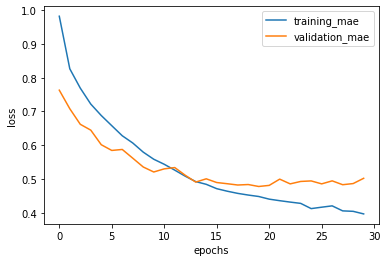

In [72]:
plot_loss(history)

In [73]:
## using the input made from tokenizer

model_100D_token =  make_model(embedding_matrix_100_token, lstm_layer_units=(64,32), dropout_rate= 0.5, dense_units=(10))
model_100D_token.summary()

history = model_100D_token.fit(X_train_padded, y_train, batch_size=128, epochs=30, validation_data=(X_dev_padded, y_dev), callbacks=callback)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         2433700   
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         84480     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

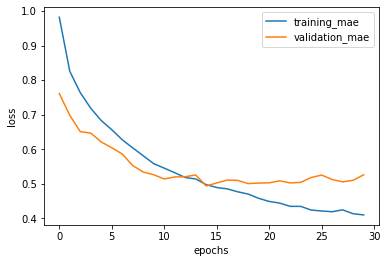

In [74]:
plot_loss(history)

#### 200D Word Embeddings 

In [75]:
embeddings_200 = import_embeddings('/content/glove.6B.200d.txt')
embedding_matrix_200 = make_embedding_matrix(word_index, 200, embeddings_200)

## makes embedding matrix with token vectors
embedding_matrix_200_token = make_embedding_matrix(word_index_token,200, embeddings_200)

Found 400000 word vectors.
Converted 13237 words (6763 misses)
Converted 18169 words (6166 misses)


In [76]:
model_200D_vector = make_model(embedding_matrix_200, lstm_layer_units=(64,32), dropout_rate= 0.5, dense_units=(10))
model_200D_vector.summary()

history = model_200D_vector.fit(X_train_vector, y_train, batch_size=128, epochs=30, validation_data=(X_dev_vector, y_dev), callbacks=callback)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         4000400   
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 128)         135680    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

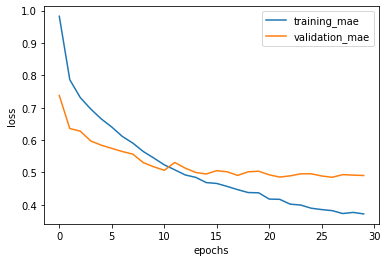

In [77]:
plot_loss(history)

In [78]:
model_200D_token =  make_model(embedding_matrix_200_token, lstm_layer_units=(64,32), dropout_rate= 0.5, dense_units=(10))
model_200D_token.summary()

history = model_200D_token.fit(X_train_padded, y_train, batch_size=128, epochs=30, validation_data=(X_dev_padded, y_dev), callbacks=callback)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 200)         4867400   
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 128)         135680    
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                650       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

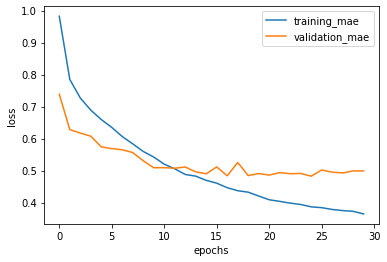

In [79]:
plot_loss(history)

### Embeddings 300D

In [80]:
embeddings_300 = import_embeddings('/content/glove.6B.300d.txt')
embedding_matrix_300 = make_embedding_matrix(word_index, 300, embeddings_300)

embedding_matrix_300_token = make_embedding_matrix(word_index_token,300, embeddings_300)

Found 400000 word vectors.
Converted 13237 words (6763 misses)
Converted 18169 words (6166 misses)


In [83]:
model_300D_vector = make_model(embedding_matrix_300, lstm_layer_units=(64,32), dropout_rate= 0.5, dense_units=(10))
model_300D_vector.summary()

history = model_300D_vector.fit(X_train_vector, y_train, batch_size=128, epochs=30, validation_data=(X_dev_vector, y_dev), callbacks=callback)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 300)         6000600   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, None, 128)         186880    
_________________________________________________________________
dropout_12 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                650       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

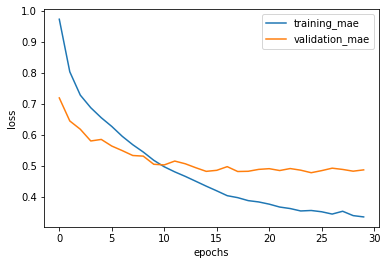

In [84]:
plot_loss(history)

In [85]:
model_300D_token =  make_model(embedding_matrix_300_token, lstm_layer_units=(64,32), dropout_rate= 0.5, dense_units=(10))
model_300D_token.summary()
history = model_300D_token.fit(X_train_padded, y_train, batch_size=128, epochs=30, validation_data=(X_dev_padded, y_dev), callbacks=callback)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 300)         7301100   
_________________________________________________________________
bidirectional_14 (Bidirectio (None, None, 128)         186880    
_________________________________________________________________
dropout_14 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                650       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

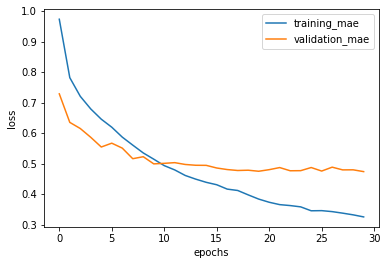

In [86]:
plot_loss(history)

### Experimentations paramters

In [132]:
model_300D_token_exp =  make_model(embedding_matrix_300_token, lstm_layer_units=(64,32), dropout_rate= 0.5, dense_units=(10), l2=0.01)
model_300D_token_exp.summary()
history = model_300D_token_exp.fit(X_train_padded, y_train, batch_size=128, epochs=60, validation_data=(X_dev_padded, y_dev), callbacks=callback)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 300)         7301100   
_________________________________________________________________
bidirectional_22 (Bidirectio (None, None, 128)         186880    
_________________________________________________________________
dropout_22 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dropout_23 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 10)                650       
_________________________________________________________________
dense_24 (Dense)             (None, 1)               

### Finding accuracy

In [88]:
y_preds = model_300D_token.predict(X_dev_padded)

In [109]:
def compare(X, y_true, y_pred):
  """
  Returns data frame with the test, actual rating, predicited rating, and rounded predicted rating
  """
  return pd.DataFrame({'Text':X_dev, 
                'Actual Rating':y_dev, 
                'Predicted Rating':np.squeeze(y_preds),
                'Rounded Rating':np.round(np.squeeze(y_preds))})
compare_df = compare(X_dev, y_dev, y_preds)

In [127]:
from sklearn.metrics import classification_report,  confusion_matrix, accuracy_score

report = classification_report(compare_df['Actual Rating'],compare_df['Rounded Rating'])
print(report)
accuracy_score(compare_df['Actual Rating'],compare_df['Rounded Rating'])

              precision    recall  f1-score   support

           1       0.55      0.41      0.47       222
           2       0.31      0.15      0.20       270
           3       0.45      0.38      0.41       949
           4       0.48      0.44      0.46      2540
           5       0.70      0.79      0.74      4132

    accuracy                           0.60      8113
   macro avg       0.50      0.43      0.46      8113
weighted avg       0.58      0.60      0.59      8113



0.5986688031554296

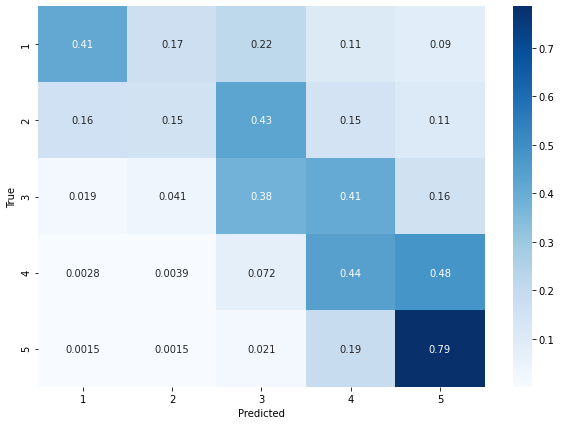

In [126]:
import seaborn as sn 

cm = confusion_matrix(compare_df['Actual Rating'],compare_df['Rounded Rating'])
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,7))
sn.heatmap(cm_norm,annot=True, cmap=plt.cm.Blues, xticklabels=list(range(1,6)), yticklabels=list(range(1,6)))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [118]:
list(range(1,6))

[1, 2, 3, 4, 5]

In [ ]:
# !zip -r /content/callback.zip /content/callbacks